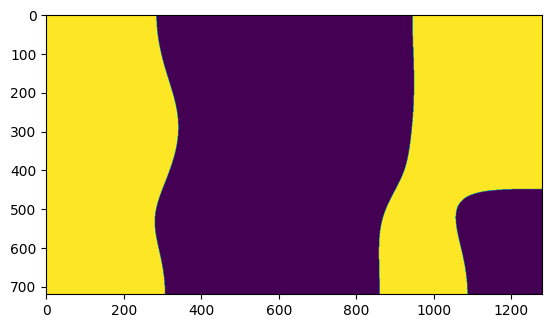

In [18]:
from utils import generate_cow_mask
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt


mask = generate_cow_mask((720,1280), 150, 0.5, 1)[0][0]
plt.imshow(mask)
plt.show()




In [6]:
init_lr = 0.001
max_iter = 50
power = 0.5

for iter in range(max_iter):
    lr = init_lr*(1 - iter/max_iter)**power
    print(lr)



0.001
0.0009899494936611666
0.0009797958971132711
0.0009695359714832658
0.0009591663046625439
0.0009486832980505138
0.000938083151964686
0.0009273618495495704
0.000916515138991168
0.0009055385138137418
0.0008944271909999159
0.0008831760866327847
0.0008717797887081347
0.0008602325267042626
0.000848528137423857
0.0008366600265340755
0.0008246211251235321
0.000812403840463596
0.0008
0.0007874007874011811
0.0007745966692414834
0.0007615773105863909
0.0007483314773547884
0.0007348469228349535
0.000721110255092798
0.0007071067811865476
0.0006928203230275509
0.0006782329983125268
0.0006633249580710799
0.000648074069840786
0.0006324555320336759
0.0006164414002968976
0.0006
0.00058309518948453
0.000565685424949238
0.0005477225575051662
0.0005291502622129182
0.0005099019513592786
0.0004898979485566356
0.00046904157598234294
0.0004472135954999579
0.00042426406871192855
0.0004
0.0003741657386773942
0.00034641016151377546
0.0003162277660168379
0.00028284271247461896
0.0002449489742783179
0.00020000